In [1]:
# %matplotlib widget

In [35]:
import os

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting, datasets, surface, image
import seaborn as sns

from matplotlib import gridspec
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, LinearSegmentedColormap
import itertools
from tqdm import tqdm

from sklearn.cluster import KMeans
from scipy import stats

## Functions

In [36]:
def _colorbar_from_array(array, threshold, cmap):
    """Generate a custom colorbar for an array.
    Internal function used by plot_img_on_surf
    array : np.ndarray
        Any 3D array.
    vmax : float
        upper bound for plotting of stat_map values.
    threshold : float
        If None is given, the colorbar is not thresholded.
        If a number is given, it is used to threshold the colorbar.
        Absolute values lower than threshold are shown in gray.
    kwargs : dict
        Extra arguments passed to _get_colorbar_and_data_ranges.
    cmap : str, optional
        The name of a matplotlib or nilearn colormap.
        Default='cold_hot'.
    """
    vmin = array.min()
    vmax = array.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmaplist = [cmap(i) for i in range(cmap.N)]

    if threshold is None:
        threshold = 0.

    # set colors to grey for absolute values < threshold
    istart = int(vmin)
    istop = int(norm(threshold, clip=True) * (cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)
    our_cmap = LinearSegmentedColormap.from_list('Custom cmap',
                                                 cmaplist, cmap.N)
    sm = plt.cm.ScalarMappable(cmap=our_cmap,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []

    return sm

In [37]:
def mkNifti(arr, mask, im, nii=True):
    out_im = np.zeros(mask.size, dtype=arr.dtype)
    inds = np.where(mask)[0]
    out_im[inds] = arr
    out_im = out_im.reshape(im.shape)
    if nii:
        out_im = nib.Nifti1Image(out_im, affine=im.affine)
    return out_im

## Paths

In [38]:
process = 'components'
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis'
data_dir = f'{top_dir}/data/raw'
out_dir = f'{top_dir}/data/interim'
figure_dir = f'{top_dir}/reports/figures/{process}'
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

In [39]:
mask = np.load(f'{out_dir}/group_reliability/sub-all_reliability-mask.npy')
mask_im = nib.load(f'{out_dir}/group_reliability/sub-all_stat-rho_statmap.nii.gz')

In [40]:
from statsmodels.stats.multitest import fdrcorrection

In [90]:
sid = 'all'
ps = np.load(f'{out_dir}/VoxelPermutation/sub-{sid}/sub-{sid}_feature-all_ps.npy')
# rs = np.load(f'{out_dir}/VoxelPermutation/sub-{sid}/sub-{sid}_feature-all_rs.npy')
y = np.load(f'{out_dir}/VoxelEncoding/sub-{sid}_y_true.npy')
y_hat = np.load(f'{out_dir}/VoxelEncoding/sub-{sid}_y_pred.npy')
rs = tools.corr2d(y, y_hat)
sig_bool, ps_corrected = fdrcorrection(ps, alpha=5e-2)
sig_bool = np.invert(sig_bool)
indices = np.where(sig_bool)[0]
rs[indices] = 0
threshold = rs[rs > 0].min()
brain_map = mkNifti(rs, mask, mask_im)

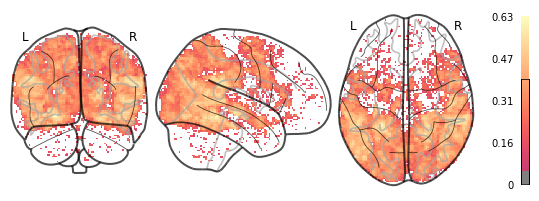

In [53]:
plotting.plot_glass_brain(brain_map, cmap=cmap,
                          colorbar=True, threshold=threshold)

In [30]:
fsaverage = datasets.fetch_surf_fsaverage()
texture = {'left': [], 'right': []}
for hemi in ['left', 'right']: 
    arr = surface.vol_to_surf(brain_map, fsaverage[f'pial_{hemi}'],
                                       interpolation='nearest')
    # arr[arr < .9] = 0 
    # for i in range(1, n_clusters-1):
    #     arr[(arr > i+.1) & (arr < i+0.9)] = 0 
    texture[hemi] = arr#.astype('int')

In [31]:
cmap = sns.color_palette("magma", as_cmap=True)

In [32]:
threshold

0.05766376484655079

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_8997/4072803274.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


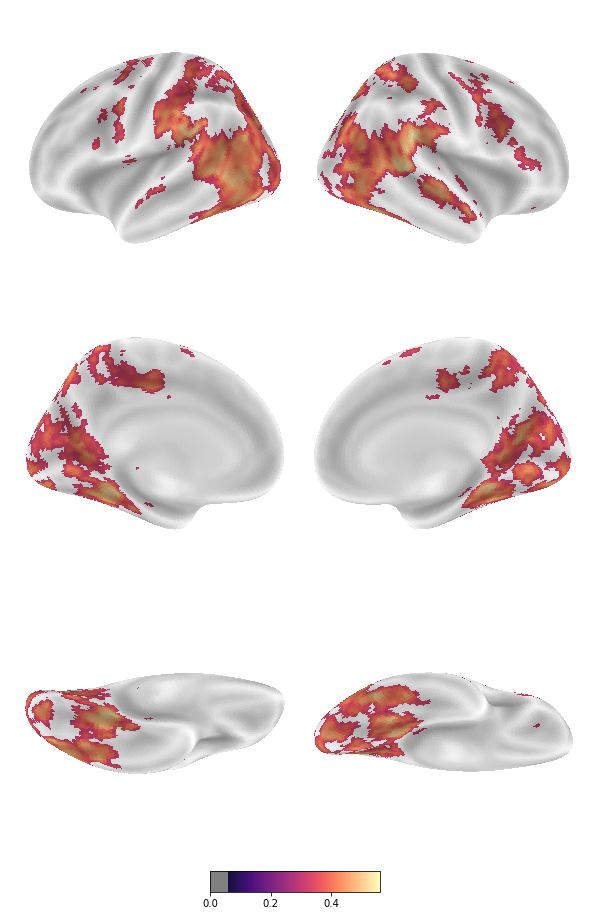

In [34]:
title = None
modes=['lateral', 'medial', 'ventral']
hemis=['left', 'right']
output_file=None
colorbar=True
vmax=None
kwargs={}

cbar_h = .25
title_h = .25 * (title is not None)
w, h = plt.figaspect((len(modes) + cbar_h + title_h) / len(hemis))
w, h = w*2, h*2
fig = plt.figure(figsize=(w, h), constrained_layout=False)
height_ratios = [title_h] + [1.] * len(modes) + [cbar_h]
grid = gridspec.GridSpec(
    len(modes) + 2, len(hemis),
    left=0., right=1., bottom=0., top=1.,
    height_ratios=height_ratios, hspace=0.0, wspace=0.0)
axes = []
for i, (mode, hemi) in enumerate(itertools.product(modes, hemis)):
    ax = fig.add_subplot(grid[i + len(hemis)], projection="3d")
    axes.append(ax)
    plotting.plot_surf_stat_map(fsaverage[f'infl_{hemi}'],
                                stat_map=texture[hemi],
                                hemi=hemi, view=mode,
                                bg_map=fsaverage[f'sulc_{hemi}'],
                                bg_on_data=True,
                                cmap=cmap,
                                darkness=.5,
                                axes=ax, colorbar=False,
                                threshold=threshold)
    # We increase this value to better position the camera of the
    # 3D projection plot. The default value makes meshes look too small.
    ax.dist = 7

if colorbar:
    array = np.hstack((texture['left'], texture['right']))
    sm = _colorbar_from_array(array, threshold, get_cmap(cmap))

    cbar_grid = gridspec.GridSpecFromSubplotSpec(3, 3, grid[-1, :])
    cbar_ax = fig.add_subplot(cbar_grid[1])
    axes.append(cbar_ax)
    fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

plt.tight_layout()
plt.savefig(f'sub-{sid}.png')

## Stuff

In [64]:
X = []
mask = np.load(f'{out_dir}/group_reliability/sub-all_reliability-mask.npy').astype('bool')
n_voxels = sum(mask)
for sid_ in range(4):
    sid = str(sid_+1).zfill(2)
    betas = np.load(f'{out_dir}/grouped_runs/sub-{sid}/sub-{sid}_train-data.npy')
    
    #Filter the beta values to the reliable voxels
    betas = betas[mask, :]
    
    #Mean center the activation within subject
    # offset_subject = betas.mean()
    # betas -= offset_subject

    if type(X) is list:
        X = betas.T
    else:
        X += betas.T
X /= 4 
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [71]:
X_scaled = X_scaled[:,:12]

In [72]:
X_scaled.shape

(200, 12)

In [73]:
X_train, X_test = X_scaled[:180,:], X_scaled[180:,:]

In [74]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA()
X_train = pca.fit_transform(X_train)

In [77]:
X_test = pca.transform(X_test)

In [78]:
X_train.shape

(180, 12)

In [7]:
df = pd.read_csv(f'{data_dir}/annotations/annotations.csv')
train = pd.read_csv(f'{data_dir}/annotations/train.csv')
df = df.merge(train)
df.sort_values(by=['video_name'], inplace=True)
df.drop(columns=['video_name'], inplace=True)
features = df.columns.to_list()

y = df.to_numpy()
scale = StandardScaler()
y_scaled = scale.fit_transform(y)

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_scaled, y_scaled)
features_by_voxels = lr.coef_

In [9]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(features_by_voxels.T)
X_new = kmeans.predict(features_by_voxels.T)
X_new += 1

In [10]:
mask = np.load(f'{out_dir}/group_reliability/sub-all_reliability-mask.npy').astype('bool')
im = nib.load(f'{out_dir}/group_reliability/sub-all_stat-rho_statmap.nii.gz')
# brain_map = comp_by_voxels_avg.argmax(axis=0) + 1
# brain_map = brain_map.astype('int')
brain_map = mkNifti(X_new, mask, im)

In [12]:
cmap = sns.color_palette('Set2', as_cmap=True)
plotting.view_img(brain_map, threshold=1, vmax=n_clusters,
                  cmap=cmap, symmetric_cmap=False)

NameError: name 'n_clusters' is not defined

In [19]:
fsaverage = datasets.fetch_surf_fsaverage()
texture = {'left': [], 'right': []}
for hemi in ['left', 'right']: 
    arr = surface.vol_to_surf(brain_map, fsaverage[f'pial_{hemi}'],
                                       interpolation='nearest')
    # arr[arr < .9] = 0 
    # for i in range(1, n_clusters-1):
    #     arr[(arr > i+.1) & (arr < i+0.9)] = 0 
    texture[hemi] = arr.astype('int')

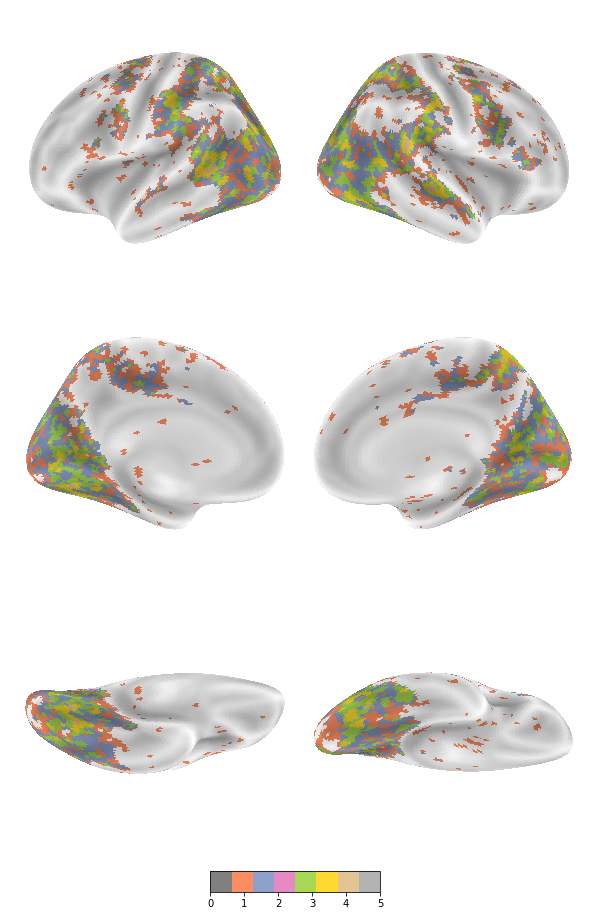

In [20]:
title = None
modes=['lateral', 'medial', 'ventral']
hemis=['left', 'right']
threshold=1
output_file=None
colorbar=True
vmax=None
kwargs={}

cbar_h = .25
title_h = .25 * (title is not None)
w, h = plt.figaspect((len(modes) + cbar_h + title_h) / len(hemis))
w, h = w*2, h*2
fig = plt.figure(figsize=(w, h), constrained_layout=False)
height_ratios = [title_h] + [1.] * len(modes) + [cbar_h]
grid = gridspec.GridSpec(
    len(modes) + 2, len(hemis),
    left=0., right=1., bottom=0., top=1.,
    height_ratios=height_ratios, hspace=0.0, wspace=0.0)
axes = []
for i, (mode, hemi) in enumerate(itertools.product(modes, hemis)):
    ax = fig.add_subplot(grid[i + len(hemis)], projection="3d")
    axes.append(ax)
    plotting.plot_surf_roi(fsaverage[f'infl_{hemi}'],
                           roi_map=texture[hemi],
                           hemi=hemi, view=mode,
                           bg_map=fsaverage[f'sulc_{hemi}'],
                           bg_on_data=True,
                           darkness=.5, threshold=1,
                           cmap=cmap,
                           axes=ax)
    # We increase this value to better position the camera of the
    # 3D projection plot. The default value makes meshes look too small.
    ax.dist = 7

if colorbar:
    array = np.hstack((texture['left'], texture['right']))
    sm = _colorbar_from_array(array, threshold, get_cmap(cmap))

    cbar_grid = gridspec.GridSpecFromSubplotSpec(3, 3, grid[-1, :])
    cbar_ax = fig.add_subplot(cbar_grid[1])
    axes.append(cbar_ax)
    fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

In [14]:
# pca = PCA(whiten=False, svd_solver='full')#, n_components=10)
# pca.fit(X_scaled)
# n_components = 10
# videos_by_comp = pca.transform(X_scaled)[:, :n_components]
# comp_by_voxels = pca.components_[:n_components, :]

# comp_by_voxels_avg = comp_by_voxels.reshape((-1, 4, n_voxels)).mean(axis=-2)

In [15]:
# plt.plot(pca.explained_variance_ratio_.cumsum(), '.-')

In [16]:
# for i in range(videos_by_comp.shape[-1]):
#     print(f'PC{i+1}')
#     print(d[d.pc == f'PC{i+1}'].drop(columns=['pc']).sort_values(by='prod', ascending=False).reset_index(drop=True))
#     print()

In [17]:
# df = pd.read_csv(f'{data_dir}/annotations/annotations.csv')
# train = pd.read_csv(f'{data_dir}/annotations/train.csv')
# df = df.merge(train)
# df.sort_values(by=['video_name'], inplace=True)
# features = df.columns.to_list()
# features.remove('video_name')

In [18]:
# from scipy.stats import pearsonr
# d = pd.DataFrame()
# for feature in features:
#     for i in range(videos_by_comp.shape[-1]):
#         pc = f'PC{i+1}'
#         prod, _ = pearsonr(df[feature], videos_by_comp[:, i])
#         new = pd.DataFrame({'feature': feature, 'pc': pc, 'prod': [prod]})
#         d = pd.concat([d, new], ignore_index=True)